In [1]:
# !pip install torch torchvision
# !pip install git+https://github.com/openai/CLIP.git
# !pip install scipy

import torch
import clip

from PIL import Image
import os

import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
from scipy.stats import spearmanr
import os
import glob
import pandas as pd

In [3]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
def get_image_embedding(image):
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(preprocessed_image)
        return image_features
    
def get_text_embedding(text):
    with torch.no_grad():
        return model.encode_text(clip.tokenize([text]).to(device))


def get_images_from_folder(folder_path):
    images = []

    for filename in os.listdir(folder_path):
        # Check if the file is an image file
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Open the image using PIL
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            # Append the image to the list
            images.append(get_image_embedding(image))

    return images




In [5]:


def find_image_embedding_arithmetics(pair1,pair2):
    first_pair = pair1.split(':')
    second_pair = pair2.split(':')
    folder_path = "/kaggle/input/dataset/Dataset/Dataset"

    first_image_embeddings = get_images_from_folder(os.path.join(folder_path ,first_pair[0]))
    second_image_embeddings = get_images_from_folder(os.path.join(folder_path ,first_pair[1]))
    third_image_embeddings = get_images_from_folder(os.path.join(folder_path ,second_pair[0]))
    fourth_image_embeddings = get_images_from_folder(os.path.join(folder_path ,second_pair[1]))


    first_image_embeddings = torch.squeeze(torch.stack(first_image_embeddings, dim=0), dim=1)
    second_image_embeddings = torch.squeeze(torch.stack(second_image_embeddings, dim=0), dim=1)
    third_image_embeddings = torch.squeeze(torch.stack(third_image_embeddings, dim=0), dim=1)
    fourth_image_embeddings = torch.squeeze(torch.stack(fourth_image_embeddings, dim=0), dim=1)

    # Average of embeddings
    first_image_embeddings = torch.mean(first_image_embeddings, dim=0)
    second_image_embeddings = torch.mean(second_image_embeddings, dim=0)
    third_image_embeddings = torch.mean(third_image_embeddings, dim=0)
    fourth_image_embeddings = torch.mean(fourth_image_embeddings, dim=0)


    offset_vector_embedding = second_image_embeddings - first_image_embeddings + third_image_embeddings

    cos_sim = F.cosine_similarity(offset_vector_embedding, fourth_image_embeddings, dim=0)

    cos_image_before_normalization = torch.rad2deg(torch.acos(cos_sim))

    print("Angle for Image embedding before normalizing: Averaging ", cos_image_before_normalization)

    rho_image_before_normalization, p_value = spearmanr(offset_vector_embedding.cpu().numpy(), fourth_image_embeddings.cpu().numpy())
    print("Spearman's correlation coefficient for Image embedding before normalizing:", rho_image_before_normalization)


    first_image_embeddings = F.normalize(first_image_embeddings , p=2,dim=0)
    second_image_embeddings = F.normalize(second_image_embeddings , p=2,dim=0)
    third_image_embeddings = F.normalize(third_image_embeddings, p=2,dim=0)
    fourth_image_embeddings = F.normalize(fourth_image_embeddings , p=2,dim=0)

    offset_vector_embedding = second_image_embeddings - first_image_embeddings + third_image_embeddings

    cos_sim = F.cosine_similarity(offset_vector_embedding, fourth_image_embeddings, dim=0)

    cos_image_after_normalization = torch.rad2deg(torch.acos(cos_sim))

    print("Angle for Image embedding after normalizing: Averaging ", cos_image_after_normalization)

    rho_image_after_normalization, p_value = spearmanr(offset_vector_embedding.cpu().numpy(), fourth_image_embeddings.cpu().numpy())
    print("Spearman's correlation coefficient for Image embedding after normalizing:", rho_image_after_normalization)

    return cos_image_before_normalization, rho_image_before_normalization,cos_image_after_normalization, rho_image_after_normalization


def find_text_embedding_arithmetics(pair1,pair2):
    first_pair = pair1.split(':')
    second_pair = pair2.split(':')

    first = get_text_embedding(first_pair[0]).squeeze(0)
    second = get_text_embedding(first_pair[1]).squeeze(0)
    third = get_text_embedding(second_pair[0]).squeeze(0)
    fourth = get_text_embedding(second_pair[1]).squeeze(0)

    offset_vector_embedding = second - first + third

    cos_sim = F.cosine_similarity(offset_vector_embedding, fourth, dim=0)

    cos_text_before_normalization = torch.rad2deg(torch.acos(cos_sim))
    

    print("Angle for text embedding before normalizing: Averaging ", cos_text_before_normalization)
    rho_text_before_normalization , p_value = spearmanr(offset_vector_embedding.cpu().numpy(), fourth.cpu().numpy())
    print("Spearman's correlation coefficient for text embedding before normalizing:", rho_text_before_normalization)


    first = F.normalize(first , p=2,dim=0)
    second = F.normalize(second , p=2,dim=0)
    third = F.normalize(third , p=2,dim=0)
    fourth = F.normalize(fourth, p=2,dim=0)

    offset_vector_embedding = second - first + third

    cos_sim = F.cosine_similarity(offset_vector_embedding, fourth, dim=0)

    cos_text_after_normalization = torch.rad2deg(torch.acos(cos_sim))

    print("Angle for text embedding after normalizing: Averaging ", cos_text_after_normalization)
    rho_text_after_normalization, p_value = spearmanr(offset_vector_embedding.cpu().numpy(), fourth.cpu().numpy())
    print("Spearman's correlation coefficient for text embedding after normalizing:", rho_text_after_normalization)

    return cos_text_before_normalization, rho_text_before_normalization, cos_text_after_normalization, rho_text_after_normalization



In [6]:
import os
import glob
import pandas as pd


def process_file(file_path, folder_path):
    lines_read = 0

    pair1 = ''
    pair2 = ''
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                parts = line.split()
                if len(parts) >= 2:
                    num, text = parts[0], ' '.join(parts[1:])
                    formatted_text = text.strip().replace('"', '')
                    if lines_read == 0:
                        pair1 = formatted_text
                    else: pair2 = formatted_text
                    lines_read += 1
                    if lines_read >= 2:
                        break

    cos_image_before_normalization, rho_image_before_normalization,cos_image_after_normalization, rho_image_after_normalization = find_image_embedding_arithmetics(pair1,pair2)
    cos_text_before_normalization, rho_text_before_normalization, cos_text_after_normalization, rho_text_after_normalization = find_text_embedding_arithmetics(pair1,pair2)

    new_data = {
        'pair1':pair1,
        'pair2':pair2,
        'cos_image_before_normalization':cos_image_before_normalization.item(),
        'rho_image_before_normalization':rho_image_before_normalization.item(),
        'cos_image_after_normalization':cos_image_after_normalization.item(),
        'rho_image_after_normalization':rho_image_after_normalization.item(),
        'cos_text_before_normalization':cos_text_before_normalization.item(),
        'rho_text_before_normalization':rho_text_before_normalization.item(),
        'cos_text_after_normalization':cos_text_after_normalization.item(),
        'rho_text_after_normalization':rho_text_after_normalization.item()
    }

    return new_data


def process_folder(folder_path,results):
    for file_path in glob.glob(os.path.join(folder_path, '*.txt')):
        data = process_file(file_path, folder_path)
        results.append(data)
        
        

    for sub_folder in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, sub_folder)
        if os.path.isdir(sub_folder_path):
            process_folder(sub_folder_path,results)
            

        


In [7]:
def get_averaged_image_embedidng(image_folder_path, word):
        image_embeddings = get_images_from_folder(os.path.join(image_folder_path ,word))
        image_embeddings = torch.squeeze(torch.stack(image_embeddings, dim=0), dim=1)
        image_embeddings = torch.mean(image_embeddings, dim=0)
        return image_embeddings
    

In [8]:
def get_averaged_image_embedidng_after_normalization(image_folder_path, word):
        image_embeddings = get_images_from_folder(os.path.join(image_folder_path ,word))
        image_embeddings = torch.squeeze(torch.stack(image_embeddings, dim=0), dim=1)
        image_embeddings = torch.mean(image_embeddings, dim=0)
        image_embeddings = F.normalize(image_embeddings, p=2,dim=0)
        return image_embeddings

In [10]:
image_folder_path = "D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\renamed_images\\new_images"
averaged_image_embeddings = {}


for word_directory in os.listdir(image_folder_path):
    image_embedidng = get_averaged_image_embedidng(image_folder_path, word_directory)
    averaged_image_embeddings[word_directory] = image_embedidng
    


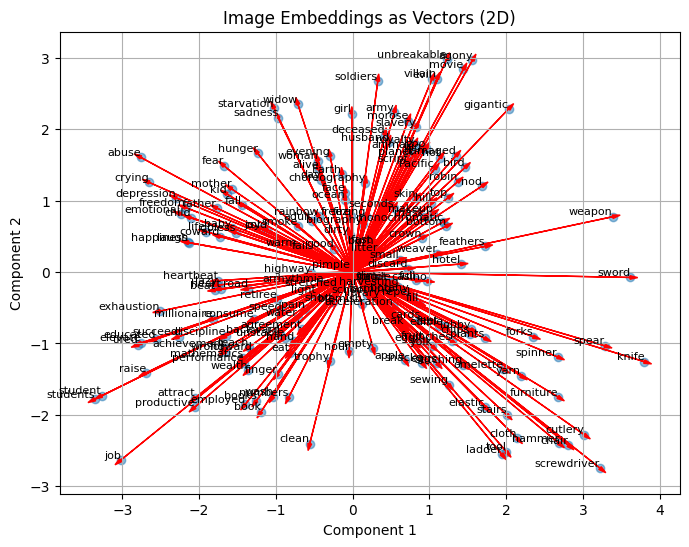

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embeddings_array = np.vstack(list(averaged_image_embeddings.values()))
labels = np.hstack(list(averaged_image_embeddings.keys()))

# Apply PCA for dimensionality reduction to 2 dimensions
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Plot the embeddings as vectors
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('Image Embeddings as Vectors (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Optionally, plot vectors connecting each point to the origin
for i in range(len(embeddings_2d)):
    plt.arrow(0, 0, embeddings_2d[i, 0], embeddings_2d[i, 1], head_width=0.05, head_length=0.1, fc='r', ec='r')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], labels[i], fontsize=8, ha='right', va='bottom')

plt.grid(True)
plt.show()


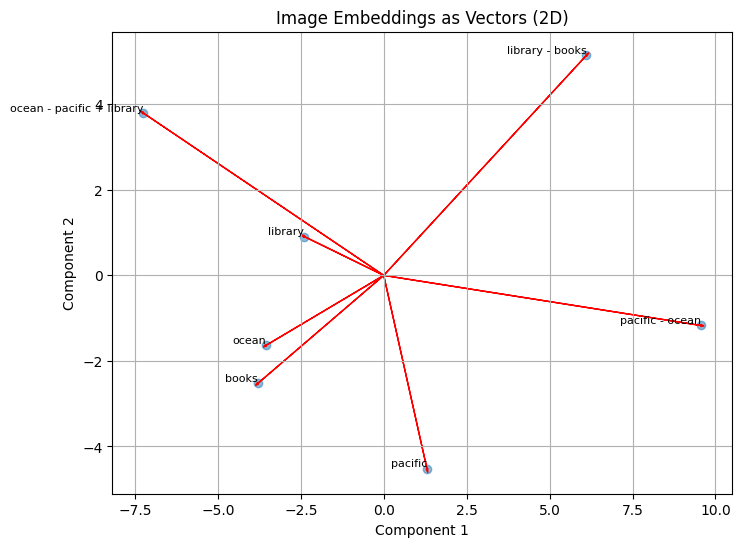

In [ ]:
pacific = averaged_image_embeddings['Pacific']
ocean = averaged_image_embeddings['ocean']
library = averaged_image_embeddings['library']
books = averaged_image_embeddings['books']

pacific_ocean = pacific - ocean

library_books = library - books

ocean_pacific_library = ocean - pacific + library

final_array = np.vstack((pacific, ocean, library, books, pacific_ocean, library_books, ocean_pacific_library))

final_array.shape

labels = np.array(['pacific','ocean','library','books','pacific - ocean','library - books', 'ocean - pacific + library'])

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(final_array)

# Plot the embeddings as vectors
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('Image Embeddings as Vectors (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Optionally, plot vectors connecting each point to the origin
for i in range(len(embeddings_2d)):
    plt.arrow(0, 0, embeddings_2d[i, 0], embeddings_2d[i, 1], head_width=0.05, head_length=0.1, fc='r', ec='r')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], labels[i], fontsize=8, ha='right', va='bottom')

plt.grid(True)
plt.show()

In [ ]:
cos_sim = F.cosine_similarity(pacific_ocean, library_books, dim=0)

cos_angle = torch.rad2deg(torch.acos(cos_sim))

print(cos_angle)

tensor(85.4270)


In [ ]:
image_folder_path = "D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\renamed_images\\new_images"
averaged_image_embeddings_after_normalization = {}


for word_directory in os.listdir(image_folder_path):
    image_embedidng = get_averaged_image_embedidng_after_normalization(image_folder_path, word_directory)
    averaged_image_embeddings_after_normalization[word_directory] = image_embedidng

d:\MS\COMP545\project\Investigating the Arithmetic of Visual Embeddings\.venv\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
def get_closest_vector(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in averaged_image_embeddings.items():
        # if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [16]:
pair1 = []
pair2 = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        pairs = line.strip().split("::")
        pair1.append(pairs[0])
        pair2.append(pairs[1])


In [12]:
import re
import random

# arithmetic_results = pd.DataFrame({'query':[],'actual_closest_word':[],'predicted_closest_words':[]})
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        lines.append(line.strip())
        
pairs = lines
count = 0

random.shuffle(pairs)
results = []

for pair in pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
    
    # random_pair2 = random.choice(pair2)

    # words = []
    # words.extend(pair.split(":"))
    # words.extend(random_pair2.split(":"))

    embedding1 = averaged_image_embeddings[words[0]]
    embedding2 = averaged_image_embeddings[words[1]]
    embedding3 = averaged_image_embeddings[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector(offset_vector, words)
    query = pair
    actual_closest_word = words[3]
    
    print("Query ", query)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    print()
    
    record = {
        "Query ": query,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
    # count = count + 1
    # if count == 1:
    #     break
    
df = pd.DataFrame(results)

df.to_csv('clip_image.csv', index=False)
    

Query  freezing:warm::gigantic:short
Actual closest word  short
Predicted closest word for image  [('gigantic', 0.8611093759536743), ('agony', 0.7526493072509766), ('warm', 0.742143988609314), ('dim', 0.7337603569030762), ('nod', 0.7234592437744141), ('day', 0.7221940755844116), ('life', 0.7217426300048828), ('light', 0.7187898755073547), ('evening', 0.7150202393531799), ('evil', 0.714967668056488)]
Actual answer index: 13  and similarity score = 0.6955201625823975

Query  fruit:apple::furniture:chair
Actual closest word  chair
Predicted closest word for image  [('furniture', 0.9122540950775146), ('chair', 0.8668066263198853), ('stairs', 0.8028289675712585), ('empty', 0.7910431027412415), ('forks', 0.7631997466087341), ('lobby', 0.7488237619400024), ('bottom', 0.7469732761383057), ('ladder', 0.7413598299026489), ('sewing', 0.7361530065536499), ('small', 0.7358331680297852)]
Actual answer index: 2  and similarity score = 0.8668066263198853

Query  fail:succeed::attract:repel
Actual clos

In [ ]:
def get_closest_vector_after_normalization(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in averaged_image_embeddings_after_normalization.items():
        if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
#         if cos_sim > max_cos_sim:
#             max_cos_sim = cos_sim
#             closest_words.append(word)
#         elif cos_sim == max_cos_sim:
#             closest_words.append(word)
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [ ]:
import re
import random

# arithmetic_results = pd.DataFrame({'query':[],'actual_closest_word':[],'predicted_closest_words':[]})
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        lines.append(line.strip())
        
pairs = lines
count = 0

random.shuffle(pairs)
results = []

for pair in pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
    embedding1 = averaged_image_embeddings_after_normalization[words[0]]
    embedding2 = averaged_image_embeddings_after_normalization[words[1]]
    embedding3 = averaged_image_embeddings_after_normalization[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector_after_normalization(offset_vector, words)
    query = pair
    actual_closest_word = words[3]
    
    print("Query ", pair)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    
    record = {
        "Query ": pair,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
    # count = count + 1
    # if count == 1:
    #     break
    
df = pd.DataFrame(results)

df.to_csv('image_results_after_normalization.csv', index=False)
    

Query  library:books::bird:feathers
Actual closest word  feathers
Predicted closest word for image  [('robin', 0.8142368793487549), ('small', 0.7901337742805481), ('animal', 0.7837984561920166), ('feathers', 0.7816281914710999), ('botany', 0.7501640915870667), ('short', 0.7323470115661621), ('fruit', 0.7322444319725037), ('plants', 0.7281821370124817), ('warm', 0.7227250933647156), ('zoo', 0.712847113609314)]
Actual answer index: 4  and similarity score = 0.7816281914710999
Query  acceleration:speed::dim:light
Actual closest word  light
Predicted closest word for image  [('light', 0.841880738735199), ('warm', 0.8250758051872253), ('day', 0.7915524244308472), ('smoke', 0.7876470685005188), ('evening', 0.7610785961151123), ('road', 0.7543259263038635), ('fast', 0.7536738514900208), ('fire', 0.7535342574119568), ('empty', 0.7535144090652466), ('fear', 0.7464408874511719)]
Actual answer index: 1  and similarity score = 0.841880738735199
Query  snacks:chips::cutlery:forks
Actual closest wor

In [27]:
import os

def process_files_in_folder(folder_path):
    file_pairs = []
    first_pair_found = False
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.txt'):
            with open(file_path, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    if not line.startswith('#'):
                        line = line.strip().split(' ')[1].strip()
                        # print(line)
                        if not first_pair_found:
                            first_line = line
                            first_pair_found = True
                        else:
                            file_pairs.append(first_line + "::" + line)
    return file_pairs

testing_folder_path = 'D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\SemEval-2012-Gold-Ratings\\Testing'
training_folder_path = 'D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\SemEval-2012-Gold-Ratings\\Training'

testing_file_pairs = process_files_in_folder(testing_folder_path)
training_file_pairs = process_files_in_folder(training_folder_path)


print("Testing File Pairs:")
print(testing_file_pairs)

print("\nTraining File Pairs:")
print(training_file_pairs)


Testing File Pairs:
['"laugh:happiness"::"nod:agreement"', '"laugh:happiness"::"laugh:amusement"', '"laugh:happiness"::"tears:sadness"', '"laugh:happiness"::"crying:sadness"', '"laugh:happiness"::"tears:sorrow"', '"laugh:happiness"::"kiss:love"', '"laugh:happiness"::"groan:pain"', '"laugh:happiness"::"laughter:amusement"', '"laugh:happiness"::"tear:sadness"', '"laugh:happiness"::"scream:terror"', '"laugh:happiness"::"handshake:cordiality"', '"laugh:happiness"::"lie:dishonesty"', '"laugh:happiness"::"kiss:passion"', '"laugh:happiness"::"laugh:hilarity"', '"laugh:happiness"::"snarl:anger"', '"laugh:happiness"::"wave:acknowledgement"', '"laugh:happiness"::"yawn:boredom"', '"laugh:happiness"::"cough:illness"', '"laugh:happiness"::"cough:sickness"', '"laugh:happiness"::"frown:discontent"', '"laugh:happiness"::"yell:anger"', '"laugh:happiness"::"grimace:disgust"', '"laugh:happiness"::"frown:sadness"', '"laugh:happiness"::"glare:anger"', '"laugh:happiness"::"frown:distaste"', '"laugh:happines

In [ ]:
all_pairs = []
all_pairs.extend(testing_file_pairs)
all_pairs.extend(training_file_pairs)

all_pairs

In [29]:
import re
text_embeddings = {}

lines = []

# with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
#     for line in file:
#         lines.append(line.strip())
        
# pairs = lines

for pair in all_pairs:
    words = [part for part in re.split(r'::|:', pair) if part]
    for word in words:
        text_embeddings[word] = get_text_embedding(word).squeeze(0)

In [44]:
len(text_embeddings)

4022

In [30]:
def get_closest_words(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in text_embeddings.items():
        if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [31]:
import re
import random

# arithmetic_results = pd.DataFrame({'query':[],'actual_closest_word':[],'predicted_closest_words':[]})
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        lines.append(line.strip())
        
pairs = lines
count = 0

random.shuffle(pairs)
results = []

for pair in all_pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
   
    word_embedding1 = get_text_embedding(words[0]).squeeze(0)
    word_embedding2 = get_text_embedding(words[1]).squeeze(0)
    word_embedding3 = get_text_embedding(words[2]).squeeze(0)
    
    offset_word = word_embedding2 - word_embedding1 + word_embedding3
    predicted_closest_words,answer_index,answer_similarity = get_closest_words(offset_word,words)

    print("Query ", pair)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    
    record = {
        "Query ": pair,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    # count = count + 1
    # if count == 1:
    #     break
    
df = pd.DataFrame(results)

df.to_csv('clip_text_results_all_pairs.csv', index=False)
    

Query  "laugh:happiness"::"nod:agreement"
Actual closest word  agreement"
Predicted closest word for image  [('nicely"', 0.9191809296607971), ('hope"', 0.9128835201263428), ('understood"', 0.9125370383262634), ('excellent"', 0.9114280939102173), ('liked"', 0.9104219675064087), ('"happiness', 0.9103196859359741), ('good"', 0.9098798036575317), ('beautiful"', 0.9090030789375305), ('holy"', 0.9084223508834839), ('halved"', 0.9081416130065918)]
Actual answer index: 1315  and similarity score = 0.851702868938446
Query  "laugh:happiness"::"laugh:amusement"
Actual closest word  amusement"
Predicted closest word for image  [('"happiness', 0.988369345664978), ('happy"', 0.9584715962409973), ('"happy', 0.9452618360519409), ('unhappiness"', 0.9329307675361633), ('joyfully"', 0.9299542307853699), ('enjoy"', 0.9288650155067444), ('love"', 0.9282221794128418), ('life"', 0.9282119274139404), ('loving"', 0.9261296391487122), ('sweet"', 0.9259846806526184)]
Actual answer index: 330  and similarity scor

In [ ]:
pip install gensim

In [36]:
import gensim.downloader as api

# Download and load the GoogleNews-vectors-negative300 Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# word2vec_model['dog']

In [48]:
def get_w2v_text_embedding(word):
    if word in word2vec_model:
        return word2vec_model[word]
    
    return None

In [61]:
import re
w2v_text_embeddings = {}

lines = []

# with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
#     for line in file:
#         lines.append(line.strip())
        
# pairs = lines

for pair in all_pairs:
    words = [part.replace('"','') for part in re.split(r'::|:', pair) if part]
    for word in words:
        emb =  get_w2v_text_embedding(word)
        if not emb is None:
            w2v_text_embeddings[word] = emb

In [62]:
len(w2v_text_embeddings)

3003

In [63]:
def get_closest_words_w2v(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in w2v_text_embeddings.items():
        # if word not in words[:3]:
            if embedding is None:
                 print("embedding None", words)
            elif offset_vector is None:
                 print("offset vector none", words)
            cos_sim = F.cosine_similarity(offset_vector, torch.tensor(embedding), dim=0).item()
            # print(cos_sim)
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [64]:
import re
import random

# arithmetic_results = pd.DataFrame({'query':[],'actual_closest_word':[],'predicted_closest_words':[]})
lines = []

# with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
#     for line in file:
#         # Remove newline character at the end of each line and append to the list
#         lines.append(line.strip())
        
# pairs = lines
# count = 0

random.shuffle(pairs)
results = []

for pair in all_pairs:
#     print(pair)
    words = [part.replace('"','') for part in re.split(r'::|:', pair) if part]
#     print(words)
   
    if words[0] in w2v_text_embeddings and words[1] in w2v_text_embeddings and words[2] in w2v_text_embeddings:
        word_embedding1 = get_w2v_text_embedding(words[0])
        word_embedding2 = get_w2v_text_embedding(words[1])
        word_embedding3 = get_w2v_text_embedding(words[2])

        
        
        offset_word = word_embedding2 - word_embedding1 + word_embedding3
        # print(offset_word)
        predicted_closest_words,answer_index,answer_similarity = get_closest_words_w2v(torch.tensor(offset_word),words)

        print("Query ", pair)
        print("Actual closest word ", words[3])
        print("Predicted closest word for image ",predicted_closest_words)
        print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
        
        record = {
            "Query ": pair,
            "Actual closest word ": words[3],
            "Predicted closest words":predicted_closest_words,
            "Actual answer index": answer_index,
            "similarity score":answer_similarity
        }

        results.append(record)

    
    # count = count + 1
    # if count == 1:
    #     break
    
df = pd.DataFrame(results)

df.to_csv('w2v_text_results_all_pairs.csv', index=False)
    

Query  "laugh:happiness"::"nod:agreement"
Actual closest word  agreement
Predicted closest word for image  [('happiness', 0.5903056859970093), ('nod', 0.5187938213348389), ('contentment', 0.5087394714355469), ('satisfaction', 0.4258820116519928), ('salvation', 0.3409641683101654), ('contentedness', 0.33942916989326477), ('eternal', 0.32729509472846985), ('prosperity', 0.3149629831314087), ('enlightenment', 0.3129850924015045), ('bliss', 0.30647367238998413)]
Actual answer index: 718  and similarity score = 0.07332854717969894
Query  "laugh:happiness"::"laugh:amusement"
Actual closest word  amusement
Predicted closest word for image  [('happiness', 1.0000001192092896), ('contentment', 0.7695192098617554), ('joy', 0.6182845830917358), ('contentedness', 0.5574802756309509), ('satisfaction', 0.528357982635498), ('prosperity', 0.5201224088668823), ('loneliness', 0.4856487810611725), ('bliss', 0.48369309306144714), ('serenity', 0.4723239839076996), ('joyful', 0.46437525749206543)]
Actual ans

In [ ]:

import torch
import torchvision.transforms as transforms
import torchvision.models as models

resnet_model = models.resnet50(pretrained=True)
# Remove the final classification layer
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
resnet_model.eval()

# Preprocess the image
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_embedding_from_resnet(image):
    input_image = transform(image).unsqueeze(0)

    with torch.no_grad():
        embeddings = resnet_model(input_image)

    return embeddings


def get_resnet_image_embeddings(folder_path):
    images = []

    for filename in os.listdir(folder_path):
        # Check if the file is an image file
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Open the image using PIL
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            # Append the image to the list
            emb = get_image_embedding_from_resnet(image)
            print(emb.shape)
            images.append(emb)

    return images

def get_averaged_image_embedidng_resnet(image_folder_path, word):
        image_embeddings = get_resnet_image_embeddings(os.path.join(image_folder_path ,word))
        print(image_embedidng)
        image_embeddings = torch.squeeze(torch.stack(image_embeddings, dim=0), dim=1)
        image_embeddings = torch.mean(image_embeddings, dim=0)
        return image_embeddings


image_folder_path = "D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\renamed_images\\new_images"
averaged_image_embeddings_resnet = {}


for word_directory in os.listdir(image_folder_path):
    image_embedidng = get_averaged_image_embedidng_resnet(image_folder_path, word_directory)
    averaged_image_embeddings_resnet[word_directory] = image_embedidng

In [24]:
def get_closest_vector_resnet(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in averaged_image_embeddings_resnet.items():
        # if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity

In [ ]:
import re
import random

# arithmetic_results = pd.DataFrame({'query':[],'actual_closest_word':[],'predicted_closest_words':[]})
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\new_pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        lines.append(line.strip())
        
pairs = lines
count = 0

random.shuffle(pairs)
results = []

for pair in pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
    
    # random_pair2 = random.choice(pair2)
    # words = []
    # words.extend(pair.split(":"))
    # words.extend(random_pair2.split(":"))

    embedding1 = averaged_image_embeddings_resnet[words[0]]
    embedding2 = averaged_image_embeddings_resnet[words[1]]
    embedding3 = averaged_image_embeddings_resnet[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector_resnet(offset_vector, words)
    query = pair
    actual_closest_word = words[3]
    
    print("Query ", query)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    print()
    
    record = {
        "Query ": query,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
    # count = count + 1
    # if count == 1:
    #     break
    
df = pd.DataFrame(results)

df.to_csv('resnet_image.csv', index=False)
    

In [32]:
random_pairs = pd.read_csv("D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\random_pairing_results.csv")
random_pairs = random_pairs['Query ']

In [36]:
import re
import random


results = []

for pair in random_pairs:
    words = [part for part in re.split(r' |:', pair) if part]

    embedding1 = averaged_image_embeddings_resnet[words[0]]
    embedding2 = averaged_image_embeddings_resnet[words[1]]
    embedding3 = averaged_image_embeddings_resnet[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector_resnet(offset_vector, words)
    query = pair 
    actual_closest_word = words[3]
    
    print("Query ", query)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    print()
    
    record = {
        "Query ": query,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
    # count = count + 1
    # if count == 1:
    #     break
    
df = pd.DataFrame(results)

df.to_csv('resnet_image_random_pairing_aligned_clip.csv', index=False)
    

Query  weapon:spear raise:elevate
Actual closest word  elevate
Predicted closest word for image  [('raise', 0.8095071315765381), ('elevate', 0.8044238090515137), ('spear', 0.7664756178855896), ('backward', 0.7644983530044556), ('short', 0.7571059465408325), ('break', 0.7562512755393982), ('joy', 0.7549944519996643), ('teach', 0.7546887397766113), ('coward', 0.7535152435302734), ('bottom', 0.753075122833252)]
Actual answer index: 2  and similarity score = 0.8044238090515137

Query  hunger:starvation smoke:fire
Actual closest word  fire
Predicted closest word for image  [('smoke', 0.9728562235832214), ('evil', 0.8476876616477966), ('sadness', 0.8323156833648682), ('morose', 0.8209320306777954), ('fire', 0.8204006552696228), ('burn', 0.8165495991706848), ('deceased', 0.8138086795806885), ('monochromatic', 0.8092449903488159), ('joy', 0.8057339787483215), ('fear', 0.8048507571220398)]
Actual answer index: 5  and similarity score = 0.8204006552696228

Query  fail:succeed cutlery:forks
Actua